# Wildfires in the California: Machine learning

Author: Lena Berger

*Disclaimer: This project was done as part of a data science boot camp. All stakeholders mentioned are fictional. This study was not commissioned by any agency or stakeholder. The project makes use of fire data collected by Short (2017) and data provided by NOAA. Some of the findings presented in this document are based on a subsamples of these datasets and are not representative of and should not be generalized to the entire database without further due. Please contact the author previous to use or further distribution of the findings or analyses. The author does not take any responsibility or liability for consequences resulting from use of these analyses.*

This jupyter notebook contains the code used for the machine learning part of the project. The goal is to predict fire size (i.e., big or not) based on weather data and some fire characteristics (e.g., location, month). We train three models: 
1. Radom Forest (GradientBoost, XGBoost)
2. Logistic regression
3. K Nearest Neighbors (KNN)

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_moons
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.evaluate import lift_score
from xgboost import XGBClassifier
from scikitplot.metrics import plot_cumulative_gain

In [2]:
# Load the data
fire_CA_sample = pd.read_csv("data/fire data updated 2020_07_25.csv", low_memory = False, dtype={"FIPS_CODE": str})

fire_CA_sample['DISCOVERY_DATE'] = pd.to_datetime(fire_CA_sample['DISCOVERY_DATE'])
fire_CA_sample['DISCOVERY_DATE']

0      2004-10-06
1      2004-10-13
2      2005-07-09
3      2005-08-24
4      2005-09-16
          ...    
8943   2001-09-23
8944   2013-11-15
8945   2013-08-06
8946   2002-06-16
8947   2003-09-23
Name: DISCOVERY_DATE, Length: 8948, dtype: datetime64[ns]

In [3]:
fire_CA_sample.columns

Index(['FOD_ID', 'FPA_ID', 'FIRE_CODE', 'FIRE_NAME', 'COMPLEX_NAME',
       'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY',
       'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
       'OWNER_CODE', 'OWNER_DESCR', 'OWNER_DESCR.1', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'BIG_FIRE', 'RAIN', 'RAIN_FLAG',
       'RAIN_DIZZLE', 'AMOUNT_RAIN_30', 'AMOUNT_RAIN_60',
       'DAYS_SINCE_LAST_RAIN', 'TEMP_AVG', 'TEMP_MIN', 'TEMP_MAX',
       'TEMP_AVG_30', 'TEMP_MIN_AVG_30', 'TEMP_MAX_AVG_30', 'TEMP_AVG_60',
       'TEMP_MIN_AVG_60', 'TEMP_MAX_AVG_60', 'THUNDER', 'FOG', 'SNOW',
       'SNOW_DEPT', 'HAIL', 'WIND_AVERAGE', 'WIND_MAX', 'WIND_GUST',
       'MISSING_DAT_CHECK', 'TIME_TO_CONTAIN', 'SIMULTANEOUS_FIRE_ONE_DAY',
       'SIMULTANEOUS_FIRE_THREE_DAYS', 'CLOSE_FIRES_THREE_YEARS',
       'CLOSE_FIRES_THREE_YEARS_AREA_BURNT'],
      dtype='object')

In [4]:
fire_CA_sample.shape

(8948, 55)

## Feature prepration and train/test-split
This section prepares the features and the training and test data. Feature selection is driven by the exploratory analysis, background knowledge, and model performance. We include features on the weather situation (e.g., temperature, rain, wind), characteristics of the fire (e.g., month, cause), and location (i.e., longitude, lattitude). Note that all features refer to the day on which the fire was discovered. An extension of this may want to include additional features throughout the course of fire. 

### Feature preparation

In [5]:
# Create the lightning, arsol, and equipment use variables
fire_CA_sample["CAUSE_LIGHTNING"] = 0
fire_CA_sample["CAUSE_ARSON"] = 0
fire_CA_sample["CAUSE_EQUIPMENT_USE"] = 0
fire_CA_sample.loc[fire_CA_sample["STAT_CAUSE_DESCR"] == "Lightning", "CAUSE_LIGHTNING"] = 1
fire_CA_sample.loc[fire_CA_sample["STAT_CAUSE_DESCR"] == "Arson", "CAUSE_ARSON"] = 1
fire_CA_sample.loc[fire_CA_sample["STAT_CAUSE_DESCR"] == "Equipment Use", "CAUSE_EQUIPMENT_USE"] = 1

# Create the month variable
# fire_CA_sample["FIRE_MONTH"] = fire_CA_sample["DISCOVERY_DATE"].dt.month
fire_CA_sample = pd.concat([fire_CA_sample, pd.get_dummies(fire_CA_sample["DISCOVERY_DATE"].dt.month, prefix = "MONTH")], axis = 1)

# Delete NaN from WIND_MAX (8 cases)
fire_CA_sample.dropna(subset = ["WIND_MAX"], inplace = True)

# Delete NaN from CLOSE_FIRES_THREE_YEARS_AREA_BURNT (loose all cases from 1992 to 1993, ca. 1000 cases)
# This variable contributes improves predicting considerably. Therefore, we are willing to compromise on cases. 
fire_CA_sample.dropna(subset = ["CLOSE_FIRES_THREE_YEARS_AREA_BURNT"], inplace = True)

In [6]:
# Extract the features
fire_CA_sample = fire_CA_sample[['BIG_FIRE', 'LATITUDE', 'LONGITUDE', 'RAIN','AMOUNT_RAIN_30', 
                                 'TEMP_AVG','TEMP_MIN', 'TEMP_MAX', 'TEMP_AVG_30', 'TEMP_MIN_AVG_30', 
                                 'TEMP_MAX_AVG_30',
                                 'WIND_AVERAGE', 'WIND_MAX','SIMULTANEOUS_FIRE_ONE_DAY', 
                                 'CLOSE_FIRES_THREE_YEARS_AREA_BURNT',
                                 "CAUSE_LIGHTNING", "CAUSE_ARSON", "CAUSE_EQUIPMENT_USE", 
                                 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4','MONTH_5', 'MONTH_6', 'MONTH_7', 
                                 'MONTH_8', 'MONTH_9', 'MONTH_10','MONTH_11', 'MONTH_12']].copy()


# Variables tried that did not yield improvement: 
# 'CLOSE_FIRES_THREE_YEARS'
# 'SIMULTANEOUS_FIRE_THREE_DAYS'
# 'TEMP_AVG_60'
# 'TEMP_MIN_AVG_60'
# 'TEMP_MAX_AVG_60'
# 'AMOUNT_RAIN_60'

In [7]:
fire_CA_sample.shape

(7602, 30)

In [8]:
fire_CA_sample.describe()

,BIG_FIRE,LATITUDE,LONGITUDE,RAIN,AMOUNT_RAIN_30,TEMP_AVG,TEMP_MIN,TEMP_MAX,TEMP_AVG_30,TEMP_MIN_AVG_30,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
count,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,...,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000,7602.000000
mean,0.498158,37.234132,-120.051748,0.006025,0.275958,71.630558,56.536596,87.302868,69.602020,84.780641,...,0.016706,0.031834,0.089450,0.170218,0.228098,0.195606,0.125230,0.075506,0.029071,0.013023
std,0.500029,2.562530,2.125358,0.051661,0.857584,11.927961,11.129100,13.487538,10.289947,11.737397,...,0.128176,0.175569,0.285411,0.375849,0.419634,0.396693,0.331002,0.264224,0.168017,0.113380
min,0.000000,32.552700,-124.399300,0.000000,0.000000,9.600000,8.100000,10.900000,29.935484,43.464516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.004221,-121.595092,0.000000,0.000000,63.500000,50.000000,78.800000,62.522581,77.293548,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.247214,-120.368056,0.000000,0.000000,72.500000,57.000000,89.600000,70.433871,86.657366,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,39.344521,-118.463209,0.000000,0.190000,80.000000,63.000000,97.900000,76.879032,93.727419,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,41.998333,-114.250800,1.530000,23.120000,108.800000,100.400000,126.000000,101.400000,113.790000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split data in training and test sets

In [9]:
# Size of the data
fire_CA_sample.shape
fire_CA_sample['BIG_FIRE'].value_counts()

0    3815
1    3787
Name: BIG_FIRE, dtype: int64

In [10]:
# Change format and extract names
names = fire_CA_sample.columns[1:]
dat_val = fire_CA_sample.values

In [11]:
# Put away the test data
Z_train, Z_test = train_test_split(dat_val, test_size = 0.4, random_state = 42)

# Split the test data
y_test = Z_test[:, 0]
X_test = np.delete(Z_test, 0, 1)

# Split the training data
y_train = Z_train[:, 0]
X_train = np.delete(Z_train, 0, 1)

## Random forest (Gradient Boost)

In [12]:
# Grid search for finding optimal learning_rate

learning_rate = [0.1, 0.2, 0.4, 0.6]
param_grid = {"learning_rate": learning_rate}

clf = GradientBoostingClassifier(n_estimators = 500)
clf_cv = GridSearchCV(clf, param_grid, cv = 5, scoring = 'roc_auc') #  scoring = 'accuracy' 'roc_auc'
clf_cv.fit(X_train, y_train)

print("The best performing parameter is:", clf_cv.best_params_) 
print("The respective score is:", clf_cv.best_score_)

The best performing parameter is: {'learning_rate': 0.1}
The respective score is: 0.7102218862039922


In [13]:
# Train and evaluate
clf = GradientBoostingClassifier(learning_rate = clf_cv.best_params_["learning_rate"])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score training set:", accuracy_score(clf.predict(X_train), y_train))
print("Accuracy score test set:", accuracy_score(y_test, y_pred))

Accuracy score training set: 0.7274720456040342
Accuracy score test set: 0.6547188424860243


In [14]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66      1522
         1.0       0.66      0.64      0.65      1519

    accuracy                           0.65      3041
   macro avg       0.65      0.65      0.65      3041
weighted avg       0.65      0.65      0.65      3041



In [15]:
# Confusion matrix
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cm

array([[1015,  507],
       [ 543,  976]], dtype=int64)

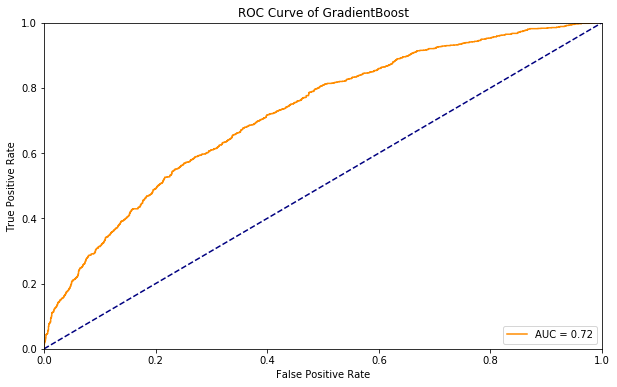

In [16]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of GradientBoost')
plt.show()

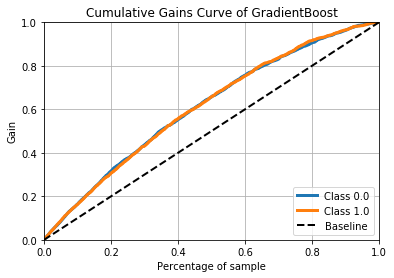

In [17]:
# Gain curve
y_probas = clf.predict_proba(X_test)
plot_cumulative_gain(y_test, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.title('Cumulative Gains Curve of GradientBoost')
plt.show()

In [18]:
# Lift score
lift_score(y_test, clf.predict(X_test), binary=True, positive_label=1)

1.3175506297618345

In [19]:
# Feature importance
important_features = pd.DataFrame(clf.feature_importances_, columns = ["importance"])
important_features = important_features.set_index(names)
important_features["importance"].sort_values().tail(20)

MONTH_5                               0.001938
CAUSE_EQUIPMENT_USE                   0.001966
RAIN                                  0.002112
MONTH_11                              0.002216
MONTH_7                               0.002987
MONTH_1                               0.003159
TEMP_AVG_30                           0.009102
CAUSE_LIGHTNING                       0.014901
TEMP_MIN_AVG_30                       0.029557
AMOUNT_RAIN_30                        0.029986
TEMP_MIN                              0.034067
WIND_AVERAGE                          0.043716
TEMP_MAX_AVG_30                       0.045727
WIND_MAX                              0.051523
TEMP_MAX                              0.057153
TEMP_AVG                              0.073939
LONGITUDE                             0.082058
LATITUDE                              0.099128
CLOSE_FIRES_THREE_YEARS_AREA_BURNT    0.186539
SIMULTANEOUS_FIRE_ONE_DAY             0.222247
Name: importance, dtype: float64

## Random Forest (XGBoost)

In [20]:
# Do a grid search 
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.2, 0.15, 0.1, 0.01]
}

estimator = XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5)

grid_search.fit(X_train, y_train)

print("The best performing parameter for max_depthis:",grid_search.best_params_["max_depth"])
print("The best performing parameter for max_depthis:",grid_search.best_params_["n_estimators"])
print("The best performing parameter for max_depthis:",grid_search.best_params_["learning_rate"])
print("The respective score is:", grid_search.best_score_)

The best performing parameter for max_depthis: 3
The best performing parameter for max_depthis: 180
The best performing parameter for max_depthis: 0.2
The respective score is: 0.7150000758315597


In [21]:
# Fit the model and evaluate
xgboost = XGBClassifier(
    objective= 'binary:logistic',
    max_depth = grid_search.best_params_["max_depth"], 
    n_estimators = grid_search.best_params_["n_estimators"], 
    learning_rate = grid_search.best_params_["learning_rate"],
    nthread=4,
    seed=42
)

xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
print("Accuracy score training set:", accuracy_score(xgboost.predict(X_train), y_train))
print("Accuracy score test set:", accuracy_score(y_test, y_pred))

Accuracy score training set: 0.8116641087480816
Accuracy score test set: 0.6688589279842158


In [22]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      1522
         1.0       0.67      0.66      0.66      1519

    accuracy                           0.67      3041
   macro avg       0.67      0.67      0.67      3041
weighted avg       0.67      0.67      0.67      3041



In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1037,  485],
       [ 522,  997]], dtype=int64)

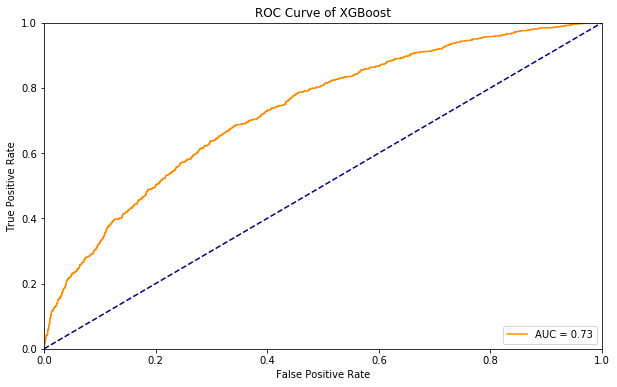

In [24]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, xgboost.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.show()

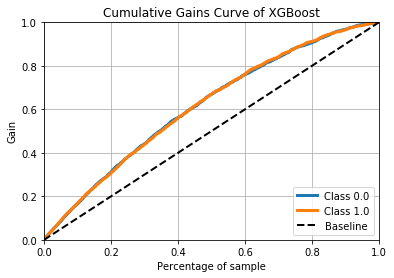

In [25]:
# Gain curve
y_probas = xgboost.predict_proba(X_test)
plot_cumulative_gain(y_test, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.title('Cumulative Gains Curve of XGBoost')
plt.show()

In [26]:
# Lift score
lift_score(y_test, xgboost.predict(X_test), binary=True, positive_label=1)

1.3468077318429006

In [27]:
# Feature importance
important_features = pd.DataFrame(xgboost.feature_importances_, columns = ["importance"])
important_features = important_features.set_index(names)
important_features["importance"].sort_values().tail(20)

TEMP_AVG_30                           0.026799
CAUSE_ARSON                           0.030237
TEMP_MIN                              0.030671
MONTH_10                              0.031708
TEMP_MAX_AVG_30                       0.033536
CAUSE_EQUIPMENT_USE                   0.033578
TEMP_MIN_AVG_30                       0.035020
AMOUNT_RAIN_30                        0.035842
WIND_AVERAGE                          0.037869
LONGITUDE                             0.038173
WIND_MAX                              0.038507
LATITUDE                              0.040943
TEMP_AVG                              0.041187
TEMP_MAX                              0.042424
MONTH_11                              0.043643
MONTH_6                               0.043689
MONTH_7                               0.048933
CAUSE_LIGHTNING                       0.057104
CLOSE_FIRES_THREE_YEARS_AREA_BURNT    0.092768
SIMULTANEOUS_FIRE_ONE_DAY             0.092788
Name: importance, dtype: float32

## Logistic Regression

In [28]:
# Grid search for finding optimal C
Cs = [1500, 1800, 2000, 2200, 2500]
param_grid = {"C": Cs}

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5, scoring = 'roc_auc') # 'accuracy'
logreg_cv.fit(X_train, y_train)

print("The best performing parameter is:", logreg_cv.best_params_) 
print("The respective score is:", logreg_cv.best_score_) 

C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

The best performing parameter is: {'C': 2500}
The respective score is: 0.6771320873146035


C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
# Fit the model
logreg = LogisticRegression(C = logreg_cv.best_params_["C"]) # logreg_cv.best_params_["C"]
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy score training set:", accuracy_score(logreg.predict(X_train), y_train))
print("Accuracy score test set:", accuracy_score(y_test, y_pred))

Accuracy score training set: 0.6272747204560404
Accuracy score test set: 0.633344294639921


C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64      1522
         1.0       0.64      0.61      0.63      1519

    accuracy                           0.63      3041
   macro avg       0.63      0.63      0.63      3041
weighted avg       0.63      0.63      0.63      3041



In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[996, 526],
       [589, 930]], dtype=int64)

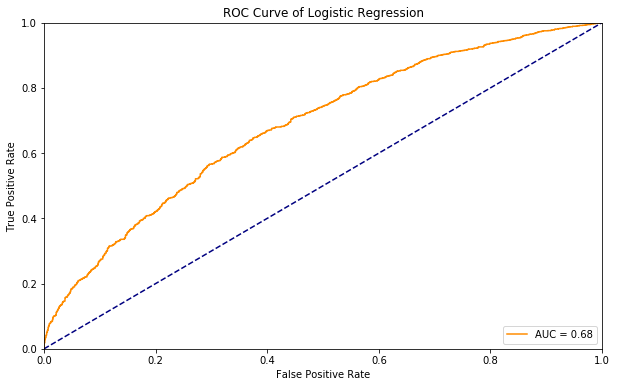

In [32]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

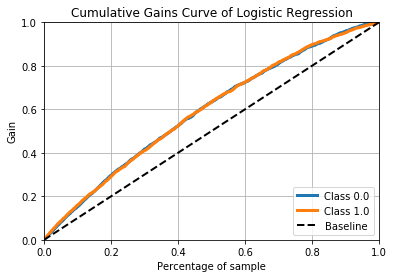

In [33]:
# Gain curve
y_probas = logreg.predict_proba(X_test)
plot_cumulative_gain(y_test, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.title('Cumulative Gains Curve of Logistic Regression')
plt.show()

In [34]:
# Lift score
lift_score(y_test, logreg.predict(X_test), binary=True, positive_label=1)

1.27873402108096

In [35]:
# Feature importance
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

pd.DataFrame(feature_importance[sorted_idx], 
             index = np.array(names)[sorted_idx], columns = ["Feature importance (0 to 100)"]).tail(20)

,Feature importance (0 to 100)
MONTH_5,6.422073
TEMP_AVG,8.636078
TEMP_AVG_30,10.422890
WIND_AVERAGE,10.561881
LATITUDE,12.219534
MONTH_11,20.432407
CAUSE_EQUIPMENT_USE,21.004883
MONTH_4,22.860043
MONTH_7,28.329373
CAUSE_ARSON,28.513165


## KNN

In [36]:
# For KNN, we need a normalized dataset. 
# Here, we normalize all ratio scaled variables. 

# Get relevant columns
cat = ['LATITUDE', 'LONGITUDE', 'RAIN','AMOUNT_RAIN_30','TEMP_AVG','TEMP_MIN',
       'TEMP_MAX', 'TEMP_AVG_30', 'TEMP_MIN_AVG_30', 'TEMP_MAX_AVG_30',
       'WIND_AVERAGE',
       'WIND_MAX','SIMULTANEOUS_FIRE_ONE_DAY', 'CLOSE_FIRES_THREE_YEARS_AREA_BURNT']

# Normalize the training set
X_train_normalized = pd.DataFrame(X_train, columns = names)
param = [[X_train_normalized[cat].mean()], [X_train_normalized[cat].std()]]
X_train_normalized[cat] = (X_train_normalized[cat]-np.array(param[0]))/np.array(param[1])
X_train_normalized = X_train_normalized.values

# We also want to normalize X_test. 
# We use the same mean and std as per recommendation by Verena Kaynig-Fittkau. 
X_test_normalized = pd.DataFrame(X_test, columns = names)
X_test_normalized[cat] = (X_test_normalized[cat]-np.array(param[0]))/np.array(param[1])
X_test_normalized = X_test_normalized.values

In [37]:
# Grid search for finding optimal n_neighbors
n_neighbors = [65, 70, 75, 80, 85, 90, 95]
param_grid = {"n_neighbors": n_neighbors}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5, scoring = 'roc_auc') #  scoring = 'accuracy'
knn_cv.fit(X_train_normalized, y_train)

print("The best performing parameter is:", knn_cv.best_params_) 
print("The respective score is:", knn_cv.best_score_)

The best performing parameter is: {'n_neighbors': 85}
The respective score is: 0.6671771816700494


In [38]:
# Fit the model
knn = KNeighborsClassifier(n_neighbors = knn_cv.best_params_["n_neighbors"]) 
knn.fit(X_train_normalized, y_train)
y_pred = knn.predict(X_test_normalized)
print("Accuracy score training set:", accuracy_score(knn.predict(X_train_normalized), y_train))
print("Accuracy score test set:", accuracy_score(y_test, y_pred))

Accuracy score training set: 0.6334137250602938
Accuracy score test set: 0.6221637619204209


In [39]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.68      0.64      1522
         1.0       0.64      0.56      0.60      1519

    accuracy                           0.62      3041
   macro avg       0.62      0.62      0.62      3041
weighted avg       0.62      0.62      0.62      3041



In [40]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1042,  480],
       [ 669,  850]], dtype=int64)

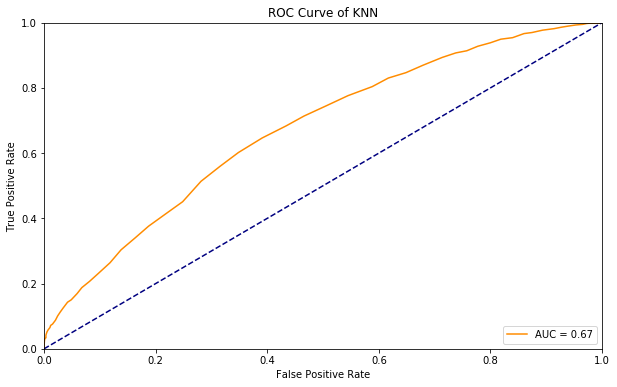

In [41]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_normalized)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNN')
plt.show()

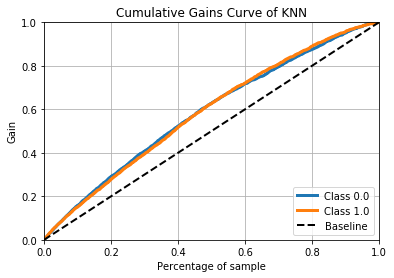

In [42]:
# Gain curve
y_probas = knn.predict_proba(X_test)
plot_cumulative_gain(y_test, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.title('Cumulative Gains Curve of KNN')
plt.show()

In [43]:
# Lift score
lift_score(y_test, knn.predict(X_test), binary=True, positive_label=1)

1.2794576962485211

## Applying the model to fires in Arizona

In [44]:
# Get the data
fire_AZ_sample = pd.read_csv("data/AZ fire data updated 2020_07_25.csv", low_memory = False, dtype={"FIPS_CODE": str})
fire_AZ_sample['DISCOVERY_DATE'] = pd.to_datetime(fire_AZ_sample['DISCOVERY_DATE'])

In [45]:
fire_AZ_sample.shape

(4038, 51)

In [46]:
# Create the lightning, arsol, and equipment use variables
fire_AZ_sample["CAUSE_LIGHTNING"] = 0
fire_AZ_sample["CAUSE_ARSON"] = 0
fire_AZ_sample["CAUSE_EQUIPMENT_USE"] = 0
fire_AZ_sample.loc[fire_AZ_sample["STAT_CAUSE_DESCR"] == "Lightning", "CAUSE_LIGHTNING"] = 1
fire_AZ_sample.loc[fire_AZ_sample["STAT_CAUSE_DESCR"] == "Arson", "CAUSE_ARSON"] = 1
fire_AZ_sample.loc[fire_AZ_sample["STAT_CAUSE_DESCR"] == "Equipment Use", "CAUSE_EQUIPMENT_USE"] = 1

# Create the month variable
fire_AZ_sample = pd.concat([fire_AZ_sample, pd.get_dummies(fire_AZ_sample["DISCOVERY_DATE"].dt.month, prefix = "MONTH")], axis = 1)

# Delete NaN from WIND_MAX (8 cases)
fire_AZ_sample.dropna(subset = ["WIND_MAX"], inplace = True)

# Delete NaN from CLOSE_FIRES_THREE_YEARS_AREA_BURNT
fire_AZ_sample.dropna(subset = ["CLOSE_FIRES_THREE_YEARS_AREA_BURNT"], inplace = True)

In [47]:
# Prepare features
fire_AZ_sample = fire_AZ_sample[['BIG_FIRE', 'LATITUDE', 'LONGITUDE', 'RAIN','AMOUNT_RAIN_30',
                                 'TEMP_AVG','TEMP_MIN', 
                                'TEMP_MAX', 'TEMP_AVG_30', 'TEMP_MIN_AVG_30', 'TEMP_MAX_AVG_30','WIND_AVERAGE', 
                                'WIND_MAX','SIMULTANEOUS_FIRE_ONE_DAY', 'CLOSE_FIRES_THREE_YEARS_AREA_BURNT',
                                "CAUSE_LIGHTNING", "CAUSE_ARSON", "CAUSE_EQUIPMENT_USE", 
                                'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4','MONTH_5', 'MONTH_6', 'MONTH_7', 
                                'MONTH_8', 'MONTH_9', 'MONTH_10','MONTH_11', 'MONTH_12']].copy()

fire_AZ_sample = np.array(fire_AZ_sample)

# Separate target and features
AZ_label = fire_AZ_sample[:, 0]
AZ_features = np.delete(fire_AZ_sample, 0, 1)

### Random Forest (GradientBoost)

In [48]:
# Use GradientBoost
AZ_pred = clf.predict(AZ_features)
print("Accuracy score test set:", accuracy_score(AZ_label, AZ_pred))

Accuracy score test set: 0.5837988826815642


In [49]:
# Classification report
print(classification_report(AZ_label, AZ_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.34      0.46      1662
         1.0       0.55      0.85      0.66      1560

    accuracy                           0.58      3222
   macro avg       0.62      0.59      0.56      3222
weighted avg       0.63      0.58      0.56      3222



In [50]:
# Confusion matrix
cm = confusion_matrix(AZ_label, AZ_pred)
cm

array([[ 562, 1100],
       [ 241, 1319]], dtype=int64)

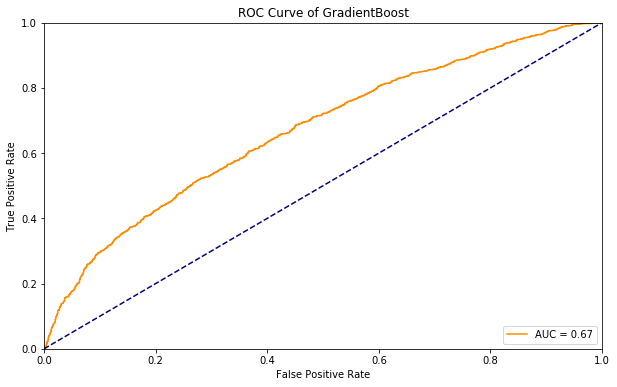

In [51]:
# ROC curve
fpr, tpr, thresholds = roc_curve(AZ_label, clf.predict_proba(AZ_features)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of GradientBoost')
plt.show()

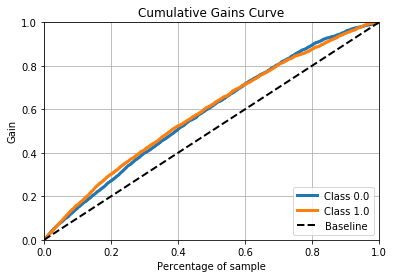

In [52]:
# Gain curve
y_probas = clf.predict_proba(AZ_features)
plot_cumulative_gain(AZ_label, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.show()

In [53]:
# Lift score
lift_score(AZ_label, clf.predict(AZ_features), binary=True, positive_label=1)

1.1261853276942158

### Random Forest (XGBoost)

In [54]:
# Use XGBoost
AZ_pred = xgboost.predict(AZ_features)
print("Accuracy score test set:", accuracy_score(AZ_label, AZ_pred))

Accuracy score test set: 0.5549348230912476


In [55]:
# Classification report
print(classification_report(AZ_label, AZ_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.28      0.40      1662
         1.0       0.53      0.84      0.65      1560

    accuracy                           0.55      3222
   macro avg       0.59      0.56      0.52      3222
weighted avg       0.59      0.55      0.52      3222



In [56]:
# Confusion matrix
cm = confusion_matrix(AZ_label, AZ_pred)
cm

array([[ 472, 1190],
       [ 244, 1316]], dtype=int64)

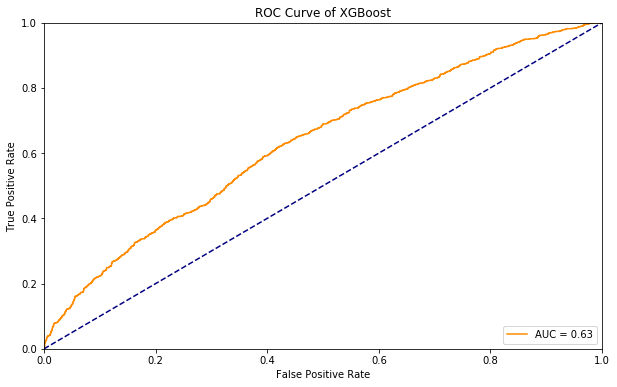

In [57]:
# ROC curve
fpr, tpr, thresholds = roc_curve(AZ_label, xgboost.predict_proba(AZ_features)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.show()

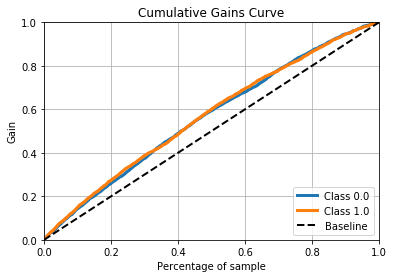

In [58]:
# Gain curve
y_probas = xgboost.predict_proba(AZ_features)
plot_cumulative_gain(AZ_label, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.show()

In [59]:
# Lift score
lift_score(AZ_label, xgboost.predict(AZ_features), binary=True, positive_label=1)

1.0846153846153848

### Logistic Regression

In [60]:
# Use Logistic Regression
AZ_pred = logreg.predict(AZ_features)
print("Accuracy score test set:", accuracy_score(AZ_label, AZ_pred))

Accuracy score test set: 0.590626939788951


In [61]:
# Classificuation report
print(classification_report(AZ_label, AZ_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.49      0.55      1662
         1.0       0.56      0.69      0.62      1560

    accuracy                           0.59      3222
   macro avg       0.60      0.59      0.59      3222
weighted avg       0.60      0.59      0.59      3222



In [62]:
# Confusion matrix
cm = confusion_matrix(AZ_label, AZ_pred)
cm

array([[ 820,  842],
       [ 477, 1083]], dtype=int64)

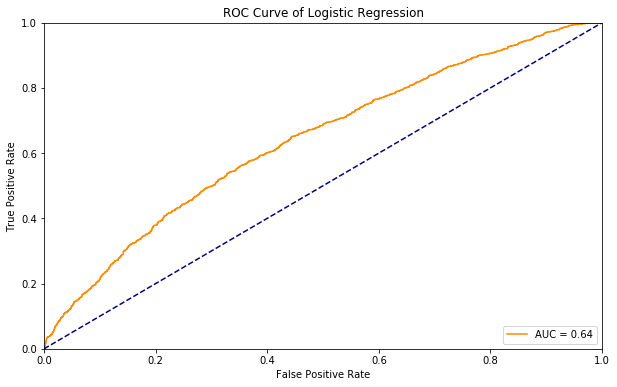

In [63]:
# ROC curve
fpr, tpr, thresholds = roc_curve(AZ_label, logreg.predict_proba(AZ_features)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

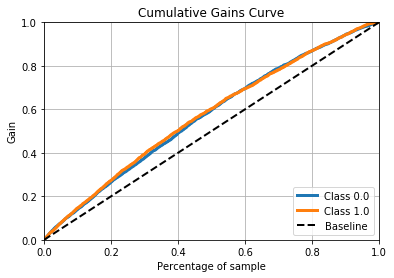

In [64]:
# Gain curve
y_probas = logreg.predict_proba(AZ_features)
plot_cumulative_gain(AZ_label, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.show()

In [65]:
# Lift score
lift_score(AZ_label, logreg.predict(AZ_features), binary=True, positive_label=1)

1.16198001998002

### KNN

In [66]:
# Use KNN
AZ_pred = knn.predict(AZ_features)
print("Accuracy score test set:", accuracy_score(AZ_label, AZ_pred))

Accuracy score test set: 0.48417132216014896


In [67]:
# Classification report
print(classification_report(AZ_label, AZ_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1662
         1.0       0.48      1.00      0.65      1560

    accuracy                           0.48      3222
   macro avg       0.24      0.50      0.33      3222
weighted avg       0.23      0.48      0.32      3222



C:\Users\Lena\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
# Confusion matrix
cm = confusion_matrix(AZ_label, AZ_pred)
cm

array([[   0, 1662],
       [   0, 1560]], dtype=int64)

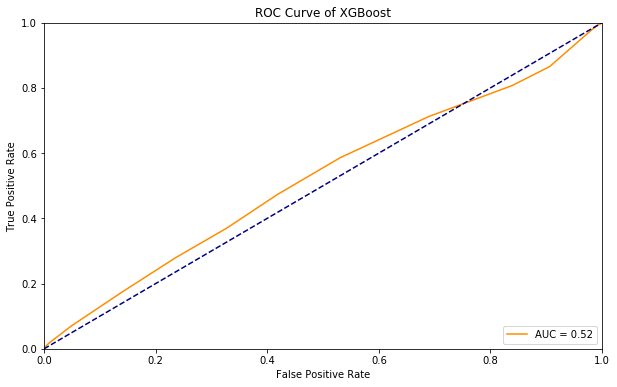

In [69]:
# ROC curve
fpr, tpr, thresholds = roc_curve(AZ_label, knn.predict_proba(AZ_features)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color='darkorange',)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='navy')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.show()

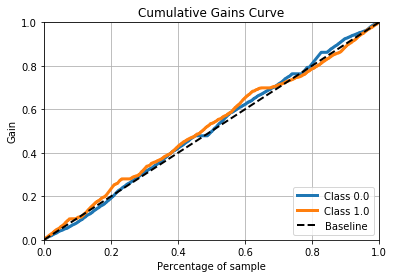

In [70]:
# Gain curve
y_probas = knn.predict_proba(AZ_features)
plot_cumulative_gain(AZ_label, y_probas) # clf.predict_proba(X_test)[:, 1]
plt.show()

In [71]:
# Lift score
lift_score(AZ_label, knn.predict(AZ_features), binary=True, positive_label=1)

1.0